In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torch.nn as nn
import torch
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import hashlib
import cv2
import random
from torch.amp import autocast, GradScaler

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_global_seed(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    try:
        import cv2
        cv2.setRNGSeed(seed)
    except:
        pass

set_global_seed(42)

In [2]:
class CustomDataset(Dataset):
    """ 
    Custom Dataset that loads all pictures into the memory at the start.
    """
    def __init__(self, root):
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        self.paths = sorted(glob(f"{root}/*/*"))

        print("Loading in ram...")
        self.images = []
        self.labels = []

        for i, path in enumerate(self.paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_name = os.path.basename(os.path.dirname(path))
            label = self.class_to_idx[label_name]

            self.images.append(img)
            self.labels.append(label)

            if i % 500 == 0:
                print(f"{i}/{len(self.paths)} pictures loaded...")

        print(f"Loading completed. {len(self.images)} pictures loaded.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]



root = os.path.join("Lung X-Ray Image", "Lung X-Ray Image")

dataset = CustomDataset(root)

total = len(dataset)
test_size = int(0.15 * total)
val_size = int(0.15 * total)
train_size = total - val_size - test_size

train_base, val_base, test_base = random_split(dataset, [train_size, val_size, test_size])

num_classes = len(dataset.class_names)

Loading in ram...
0/3319 pictures loaded...
500/3319 pictures loaded...
1000/3319 pictures loaded...
1500/3319 pictures loaded...
2000/3319 pictures loaded...
2500/3319 pictures loaded...
3000/3319 pictures loaded...
Loading completed. 3319 pictures loaded.


In [3]:
class TransformDataset(Dataset):
    """" 
    This wrapper applies transformations on-the-fly to the existing dataset.
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        
        if self.transform:
            img = self.transform(img)
        return img, label

# Vision transformer definition
Principal components:

1. PatchEmbedding : Slices the picture in patches and project them in the embedding space.
2. MultiHeadAttention : Multi head attention mecanism.
3. MLP : Feed-forward network with GELU activation
4. TransformerBlock : Full bloc with attention + MLP + layer norm + residual connections

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=299, patch_size=16, in_channels=3, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim=256, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=2.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=299, patch_size=16, in_channels=3, num_classes=3,
                embed_dim=256, depth=6, num_heads=8, mlp_ratio=2.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        self.head = nn.Linear(embed_dim, num_classes)
        
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
    def forward(self, x):
        B = x.shape[0]
        
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        
        return x

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        with autocast(device):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach()

    return (running_loss / len(loader)).item()


def validate(model, loader, criterion, device):
    model.eval()
    total_correct = 0
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast(device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.detach()
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum()
            total_samples += labels.size(0)

    avg_loss = (running_loss / len(loader)).item()
    accuracy = (total_correct / total_samples).item()
    
    return avg_loss, accuracy

# Hyper parameter search

We test the best parameters of the vit, as well as the best combinaison of data augmentation

In [7]:
class CLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(img)
            
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            
            if len(img_np.shape) == 3:
                img_clahe = np.zeros_like(img_np)
                for i in range(img_np.shape[2]):
                    img_clahe[:, :, i] = clahe.apply(img_np[:, :, i])
            else:
                img_clahe = clahe.apply(img_np)
            
            img = torch.from_numpy(img_clahe).float() / 255.0
            if len(img_clahe.shape) == 3:
                img = img.permute(2, 0, 1)
        
        return img

class GaussianNoise:
    def __init__(self, mean=0.0, std=0.02, p=0.3):
        self.mean = mean
        self.std = std
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0.0, 1.0)
        return img

class RandomGamma:
    def __init__(self, gamma_range=(0.8, 1.2), p=0.5):
        self.gamma_range = gamma_range
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            gamma = random.uniform(*self.gamma_range)
            img = torch.pow(img, gamma)
        return img

class LightElasticTransform:
    def __init__(self, alpha=10, sigma=3, p=0.2):
        self.alpha = alpha
        self.sigma = sigma
        self.p = p
    
    def __call__(self, img):
        if random.random() < self.p:
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
            else:
                img_np = np.array(img)
            
            shape = img_np.shape[:2]
            
            dx = cv2.GaussianBlur(
                (np.random.rand(*shape) * 2 - 1), 
                (0, 0), 
                self.sigma
            ) * self.alpha
            dy = cv2.GaussianBlur(
                (np.random.rand(*shape) * 2 - 1), 
                (0, 0), 
                self.sigma
            ) * self.alpha
            
            x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
            indices = (y + dy).astype(np.float32), (x + dx).astype(np.float32)
            
            if len(img_np.shape) == 3:
                distorted = np.zeros_like(img_np)
                for i in range(img_np.shape[2]):
                    distorted[:, :, i] = cv2.remap(
                        img_np[:, :, i],
                        indices[1], indices[0],
                        cv2.INTER_LINEAR
                    )
            else:
                distorted = cv2.remap(
                    img_np,
                    indices[1], indices[0],
                    cv2.INTER_LINEAR
                )
            
            img = torch.from_numpy(distorted).float()
            if len(distorted.shape) == 3:
                img = img.permute(2, 0, 1)
        
        return img

def get_augmentation_presets():
    presets = {
        "baseline": T.Compose([
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "clahe_only": T.Compose([
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.7),
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "geometric_light": T.Compose([
            T.RandomRotation(degrees=10),
            T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "clahe_geometric": T.Compose([
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.7),
            T.RandomRotation(degrees=10),
            T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "intensity": T.Compose([
            T.ColorJitter(brightness=0.2, contrast=0.2),
            RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "conservative": T.Compose([
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
            T.RandomRotation(degrees=10),
            T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            T.ColorJitter(brightness=0.2, contrast=0.2),
            RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
            GaussianNoise(mean=0.0, std=0.02, p=0.3),
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "aggressive": T.Compose([
            CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=0.7),
            T.RandomRotation(degrees=15),
            T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            T.RandomHorizontalFlip(p=0.5),
            LightElasticTransform(alpha=10, sigma=3, p=0.3),
            T.ColorJitter(brightness=0.3, contrast=0.3),
            RandomGamma(gamma_range=(0.7, 1.3), p=0.6),
            GaussianNoise(mean=0.0, std=0.03, p=0.4),
            T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.3),
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "clahe_intensity": T.Compose([
            CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
            T.ColorJitter(brightness=0.25, contrast=0.25),
            RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
            GaussianNoise(mean=0.0, std=0.02, p=0.3),
            T.Normalize(mean=[0.5], std=[0.5])
        ]),
        
        "no_flip": T.Compose([
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.6),
            T.RandomRotation(degrees=12),
            T.RandomAffine(degrees=0, translate=(0.08, 0.08), scale=(0.92, 1.08)),
            LightElasticTransform(alpha=8, sigma=3, p=0.25),
            T.ColorJitter(brightness=0.25, contrast=0.25),
            RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
            GaussianNoise(mean=0.0, std=0.025, p=0.35),
            T.Normalize(mean=[0.5], std=[0.5])
        ])
    }
    
    return presets

In [ ]:
import itertools

def hyperparameter_search(train_base, val_base, num_classes, device):
    aug_presets = get_augmentation_presets()
    
    param_grid = {
        "augmentation": list(aug_presets.keys()),
        "lr": [1e-4, 5e-5],
        "weight_decay": [0.01, 0.05],
        "dropout": [0.1, 0.2],
        "embed_dim": [256],
        "depth": [6],
        "num_heads": [8],
        "patch_size": [23],
        "mlp_ratio": [2.0]
    }

    best_acc = 0
    best_params = None
    best_model_state = None
    results_history = []
    
    total_combinations = 1
    for values in param_grid.values():
        total_combinations *= len(values)
    
    print(f"Total combinations: {total_combinations}")


    scaler = torch.amp.GradScaler('cuda')
    current_combination = 0

    for aug_name, lr, wd, dropout, embed_dim, depth, num_heads, patch_size, mlp_ratio in itertools.product(
        param_grid["augmentation"],
        param_grid["lr"],
        param_grid["weight_decay"],
        param_grid["dropout"],
        param_grid["embed_dim"],
        param_grid["depth"],
        param_grid["num_heads"],
        param_grid["patch_size"],
        param_grid["mlp_ratio"]
    ):
        current_combination += 1
        
        print(f"Test {current_combination}/{total_combinations}")


        train_transform = aug_presets[aug_name]
        val_test_transform = T.Compose([
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
            T.Normalize(mean=[0.5], std=[0.5])
        ])
        
        train_dataset = TransformDataset(train_base, transform=train_transform)
        val_dataset = TransformDataset(val_base, transform=val_test_transform)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=64, 
            shuffle=True, 
            num_workers=0, 
            pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=64, 
            shuffle=False, 
            num_workers=0, 
            pin_memory=True
        )

        model = VisionTransformer(
            img_size=299,
            patch_size=patch_size,
            in_channels=3,
            num_classes=num_classes,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            dropout=dropout
        ).to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Model parameters: {total_params:,}")

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=wd,
            betas=(0.9, 0.999)
        )
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=15,
            eta_min=lr * 0.01
        )

        num_epochs = 30
        best_val_acc_current = 0
        
        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
            val_loss, val_acc = validate(model, val_loader, criterion, device)
            scheduler.step()
            
            if val_acc > best_val_acc_current:
                best_val_acc_current = val_acc
            
            if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
                print(f"  Epoch {epoch+1:2d}/{num_epochs}: "
                      f"train_loss={train_loss:.4f}, "
                      f"val_loss={val_loss:.4f}, "
                      f"val_acc={val_acc:.4f}")
        

        current_params = {
            "augmentation": aug_name,
            "lr": lr,
            "weight_decay": wd,
            "dropout": dropout,
            "embed_dim": embed_dim,
            "depth": depth,
            "num_heads": num_heads,
            "patch_size": patch_size,
            "mlp_ratio": mlp_ratio
        }
        
        results_history.append({
            "params": current_params,
            "accuracy": best_val_acc_current
        })
        
        if best_val_acc_current > best_acc:
            best_acc = best_val_acc_current
            best_params = current_params
            best_model_state = model.state_dict()
            print(f"New best model. Accuracy: {best_acc:.4f}")

    print(f"\n{'='*80}")
    print("Search completed.")

    print(f"Best validation accuracy: {best_acc:.4f}")
    print(f"Best hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key:15s}: {value}")

    return best_params, best_acc, best_model_state, results_history

In [ ]:
hyperparameter_search(
    train_base, 
    val_base, 
    num_classes, 
    device
)

Total combinations: 72
Test 1/72
Model parameters: 3,614,211
  Epoch  5/30: train_loss=0.6409, val_loss=1.6805, val_acc=0.4538
  Epoch 10/30: train_loss=0.4947, val_loss=1.5523, val_acc=0.5327
  Epoch 15/30: train_loss=0.4171, val_loss=1.4219, val_acc=0.5538
  Epoch 20/30: train_loss=0.4174, val_loss=1.3739, val_acc=0.5288
  Epoch 25/30: train_loss=0.4214, val_loss=0.9564, val_acc=0.7058
  Epoch 30/30: train_loss=0.3765, val_loss=1.1212, val_acc=0.6327
New best model. Accuracy: 0.7327
Test 2/72
Model parameters: 3,614,211
  Epoch  5/30: train_loss=0.6942, val_loss=1.7393, val_acc=0.3865
  Epoch 10/30: train_loss=0.5123, val_loss=0.8810, val_acc=0.6885
  Epoch 15/30: train_loss=0.4366, val_loss=0.7369, val_acc=0.7212
  Epoch 20/30: train_loss=0.4390, val_loss=0.7330, val_acc=0.7115
  Epoch 25/30: train_loss=0.4308, val_loss=0.9425, val_acc=0.6173
  Epoch 30/30: train_loss=0.4344, val_loss=0.9419, val_acc=0.6000
New best model. Accuracy: 0.7423
Test 3/72
Model parameters: 3,614,211
  Epo

({'augmentation': 'clahe_intensity',
  'lr': 0.0001,
  'weight_decay': 0.05,
  'dropout': 0.2,
  'embed_dim': 256,
  'depth': 6,
  'num_heads': 8,
  'patch_size': 23,
  'mlp_ratio': 2.0},
 0.8653846383094788,
 OrderedDict([('cls_token',
               tensor([[[-3.0454e-02, -4.9788e-02, -1.0431e-02,  1.9194e-02,  1.4598e-02,
                          9.5124e-03, -3.8542e-02, -6.3041e-03, -3.8607e-03,  7.4634e-03,
                          1.4765e-02,  8.1570e-03, -1.7520e-02, -4.3119e-02,  9.3439e-03,
                          1.3200e-03,  1.9648e-02, -2.2920e-02,  7.8668e-04, -1.4441e-02,
                          3.6988e-03,  2.3829e-03,  6.4531e-03,  2.4592e-02,  4.8728e-03,
                         -1.4631e-02, -1.5208e-02, -3.4560e-02, -1.7369e-02,  2.4391e-03,
                         -2.1787e-02,  2.0409e-02,  5.9979e-03, -1.1930e-02,  1.8990e-02,
                         -1.8362e-02, -2.5550e-02,  4.4272e-02, -6.7931e-03,  7.5171e-03,
                         -1.1749e-02, -2.76

Best parameters :
- lr = 0.0001
- weight_decay = 0.05
- dropout = 0.2
- embed_dim = 256
- depth = 6
- num_heads = 8
- patch_size = 23
- mlp_ratio = 2.0

Best data augmentation :
- CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6)    
- T.ColorJitter(brightness=0.25, contrast=0.25)
- RandomGamma(gamma_range=(0.8, 1.2), p=0.5)
- GaussianNoise(mean=0.0, std=0.02, p=0.3)

# Training model on best parameters

In [8]:
train_transform = T.Compose([
    CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
    GaussianNoise(mean=0.0, std=0.02, p=0.3),
    T.Normalize(mean=[0.5], std=[0.5])
])

val_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

test_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = TransformDataset(train_base, transform=train_transform)
val_dataset   = TransformDataset(val_base,   transform=val_transform)
test_dataset  = TransformDataset(test_base,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=2*64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=2*64, shuffle=False, num_workers=0, pin_memory=True)

In [13]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

if device == 'cuda':
    torch.cuda.empty_cache()

warmup_epochs = 10
num_epochs = 50

vit = VisionTransformer(
    img_size=299,
    patch_size=23,
    in_channels=3,
    num_classes=num_classes,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_ratio=2.0,
    dropout=0.2
).to(device)

total_params = sum(p.numel() for p in vit.parameters())
trainable_params = sum(p.numel() for p in vit.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=0.0001, weight_decay=0.1)

# Warm up
scheduler_warmup = LinearLR(
    optimizer, 
    start_factor=0.01, 
    total_iters=warmup_epochs
)

# Cosine descent
scheduler_cosine = CosineAnnealingLR(
    optimizer, 
    T_max=num_epochs - warmup_epochs
)


scheduler = SequentialLR(
    optimizer,
    schedulers=[scheduler_warmup, scheduler_cosine],
    milestones=[warmup_epochs]
)
scaler = torch.amp.GradScaler('cuda')

train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(vit, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = validate(vit, val_loader, criterion, device)

    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(vit.state_dict(), "saved_models/vit.pth")
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, lr={scheduler.get_last_lr()[0]:.6f} | New best saved.")
    else:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, lr={scheduler.get_last_lr()[0]:.6f}")

if device == 'cuda':
    torch.cuda.empty_cache()

Total parameters: 3,614,211
Trainable parameters: 3,614,211
Epoch 1/50: train_loss=1.1556, val_loss=1.1066, val_acc=0.3642, lr=0.000011 | New best saved.
Epoch 2/50: train_loss=1.1182, val_loss=1.0543, val_acc=0.4809, lr=0.000021 | New best saved.
Epoch 3/50: train_loss=1.0975, val_loss=1.0230, val_acc=0.4930, lr=0.000031 | New best saved.
Epoch 4/50: train_loss=1.0790, val_loss=0.9852, val_acc=0.5493, lr=0.000041 | New best saved.
Epoch 5/50: train_loss=1.0470, val_loss=0.9378, val_acc=0.5835, lr=0.000051 | New best saved.
Epoch 6/50: train_loss=0.9984, val_loss=0.8456, val_acc=0.6761, lr=0.000060 | New best saved.
Epoch 7/50: train_loss=0.8912, val_loss=0.8719, val_acc=0.6358, lr=0.000070
Epoch 8/50: train_loss=0.7827, val_loss=0.7129, val_acc=0.7002, lr=0.000080 | New best saved.
Epoch 9/50: train_loss=0.7367, val_loss=0.7522, val_acc=0.7002, lr=0.000090


c:\Users\TUF Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 10/50: train_loss=0.6905, val_loss=0.7890, val_acc=0.6801, lr=0.000100
Epoch 11/50: train_loss=0.6387, val_loss=0.7013, val_acc=0.7183, lr=0.000100 | New best saved.
Epoch 12/50: train_loss=0.5834, val_loss=0.7838, val_acc=0.7002, lr=0.000099
Epoch 13/50: train_loss=0.5877, val_loss=0.6592, val_acc=0.7525, lr=0.000099 | New best saved.
Epoch 14/50: train_loss=0.5786, val_loss=0.6611, val_acc=0.7505, lr=0.000098
Epoch 15/50: train_loss=0.5595, val_loss=0.6051, val_acc=0.7545, lr=0.000096 | New best saved.
Epoch 16/50: train_loss=0.5355, val_loss=0.5595, val_acc=0.7706, lr=0.000095 | New best saved.
Epoch 17/50: train_loss=0.5419, val_loss=0.6194, val_acc=0.7807, lr=0.000093
Epoch 18/50: train_loss=0.5271, val_loss=0.6670, val_acc=0.7706, lr=0.000090
Epoch 19/50: train_loss=0.5149, val_loss=0.5434, val_acc=0.7907, lr=0.000088 | New best saved.
Epoch 20/50: train_loss=0.5007, val_loss=0.5913, val_acc=0.7807, lr=0.000085
Epoch 21/50: train_loss=0.4882, val_loss=0.5462, val_acc=0.7887

### Learning curves

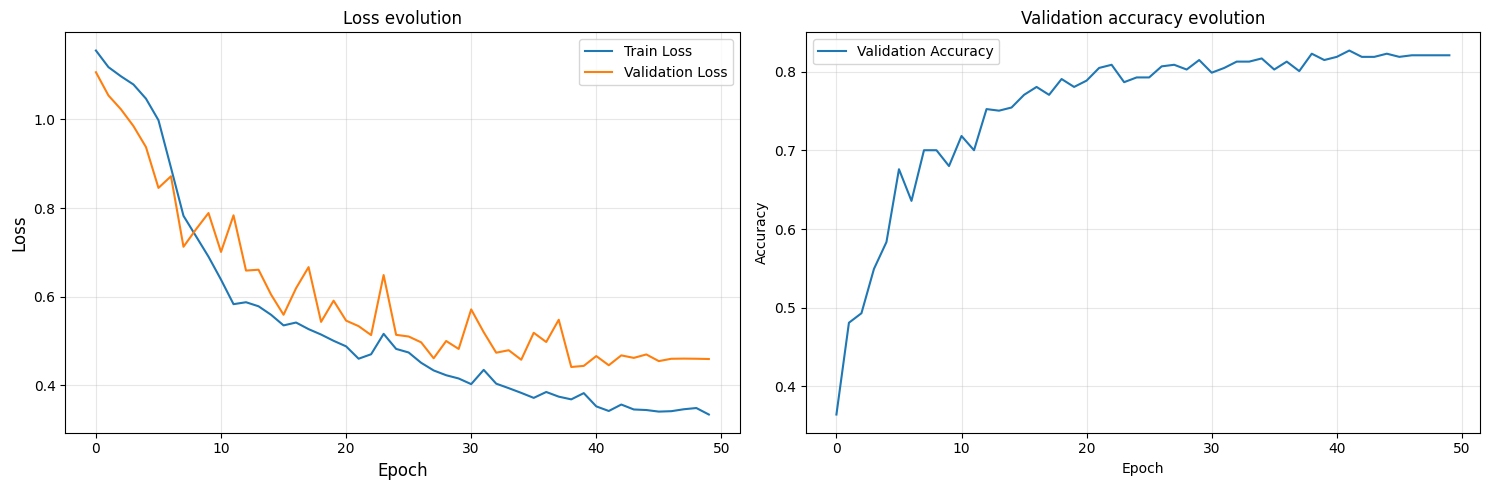

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation accuracy evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation

In [15]:
test_loader  = DataLoader(test_dataset,  batch_size=2*64, shuffle=False, num_workers=0, pin_memory=True)

vit = VisionTransformer(
    img_size=299,
    patch_size=23,
    in_channels=3,
    num_classes=num_classes,
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_ratio=2.0,
    dropout=0.1
).to(device)
vit.load_state_dict(torch.load("saved_models/vit.pth"))
vit.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(23, 23), stride=(23, 23))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=3, bias=True)
)

Test accuracy: 0.8370

Classification Report:
                 precision    recall  f1-score   support

   Lung_Opacity     0.8280    0.8075    0.8176       161
         Normal     0.7626    0.8251    0.7927       183
Viral Pneumonia     0.9507    0.8824    0.9153       153

       accuracy                         0.8370       497
      macro avg     0.8471    0.8383    0.8418       497
   weighted avg     0.8417    0.8370    0.8385       497



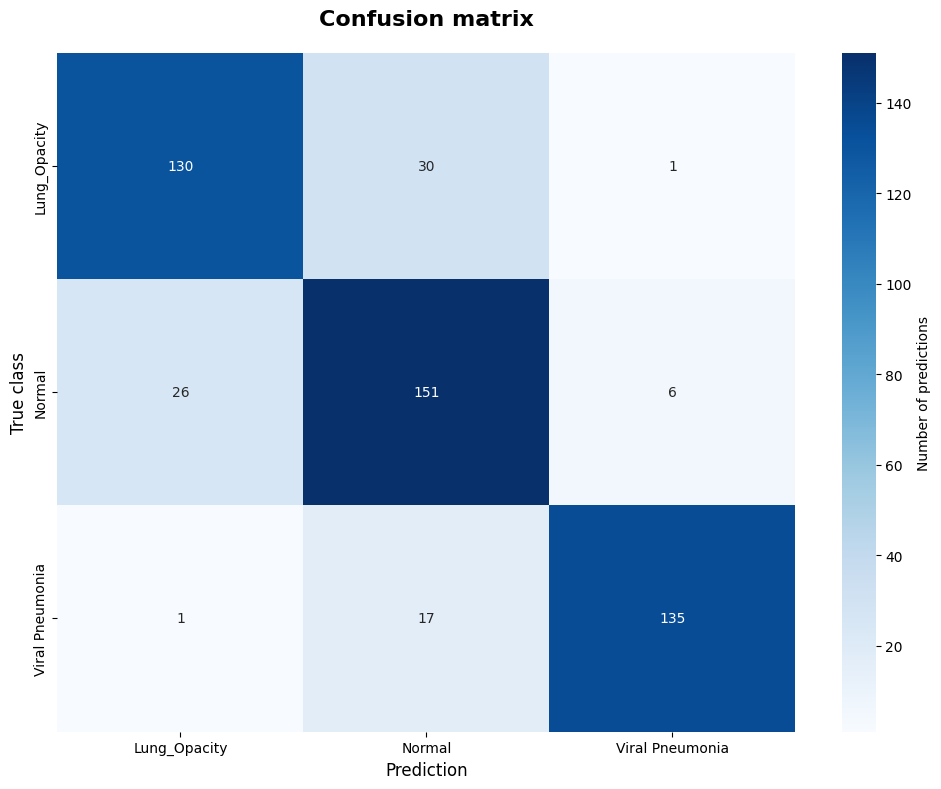

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with autocast(device):
            outputs = vit(images)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_names, digits=4))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.class_names, 
            yticklabels=dataset.class_names,
            cbar_kws={'label': 'Number of predictions'})
plt.title('Confusion matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.tight_layout()
plt.show()

# Resulting attention map

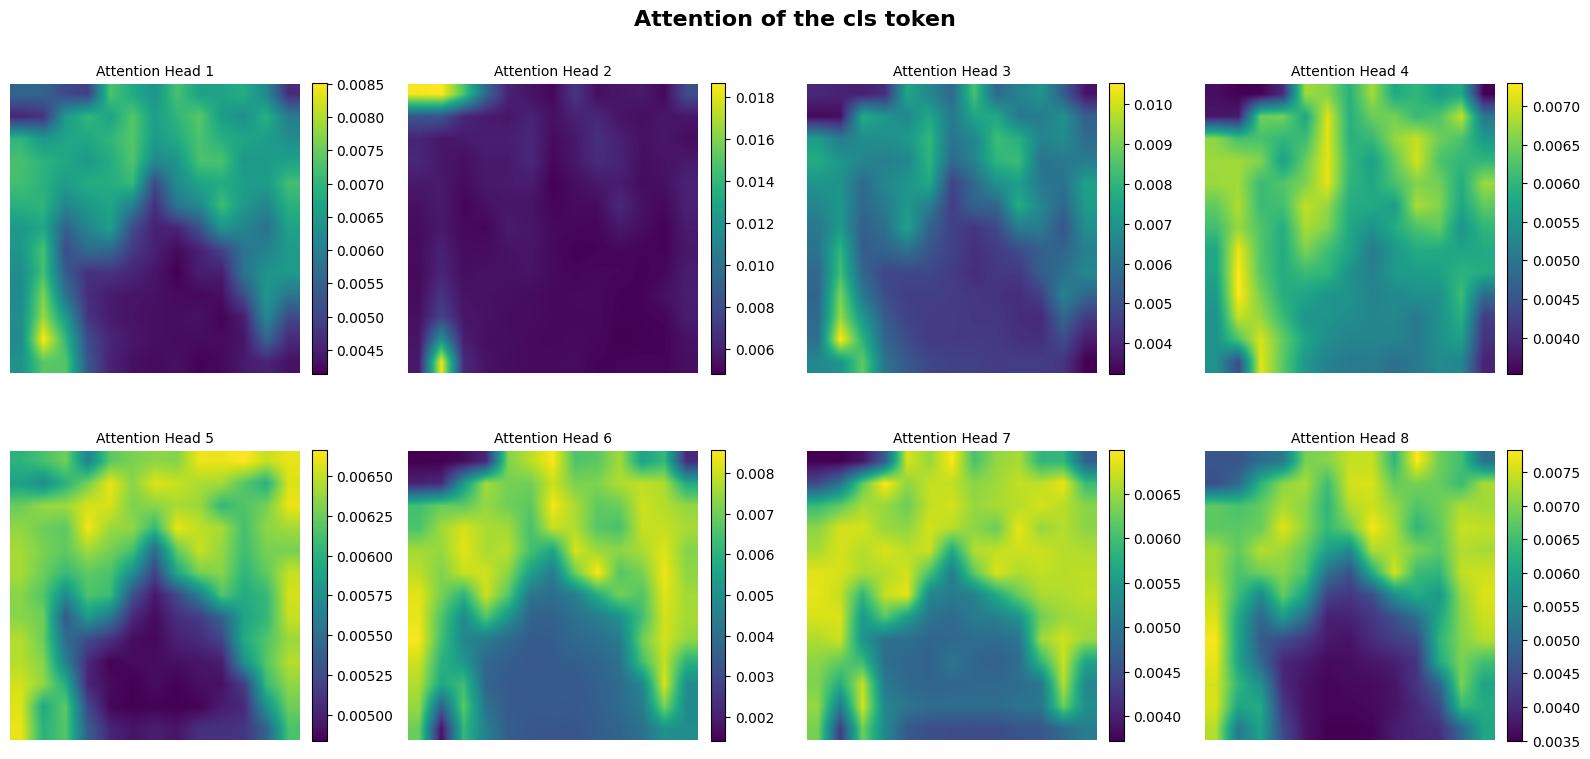

In [17]:
def get_attention_maps(model, image):
    model.eval()
    attention_maps = []
    
    def hook_fn(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0]).reshape(B, N, 3, module.num_heads, module.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (module.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attention_maps.append(attn.detach().cpu())
    
    hooks = []
    for block in model.blocks:
        hooks.append(block.attn.register_forward_hook(hook_fn))
    
    with torch.no_grad():
        _ = model(image)
    
    for hook in hooks:
        hook.remove()
    
    return attention_maps

first_image, first_label = dataset[0]
first_image_tensor = torch.from_numpy(first_image).permute(2, 0, 1).float() / 255.0
first_image_tensor = train_transform(first_image_tensor)
first_image_tensor = first_image_tensor.unsqueeze(0).to(device)


attention_maps = get_attention_maps(vit, first_image_tensor)

last_attn = attention_maps[-1][0]
n_patches = int(np.sqrt(last_attn.shape[1] - 1))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, last_attn.shape[0])):
    attn_weights = last_attn[i, 0, 1:].reshape(n_patches, n_patches).numpy()
    
    im = axes[i].imshow(attn_weights, cmap='viridis', interpolation='bilinear')
    axes[i].set_title(f'Attention Head {i+1}', fontsize=10)
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle('Attention of the cls token', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

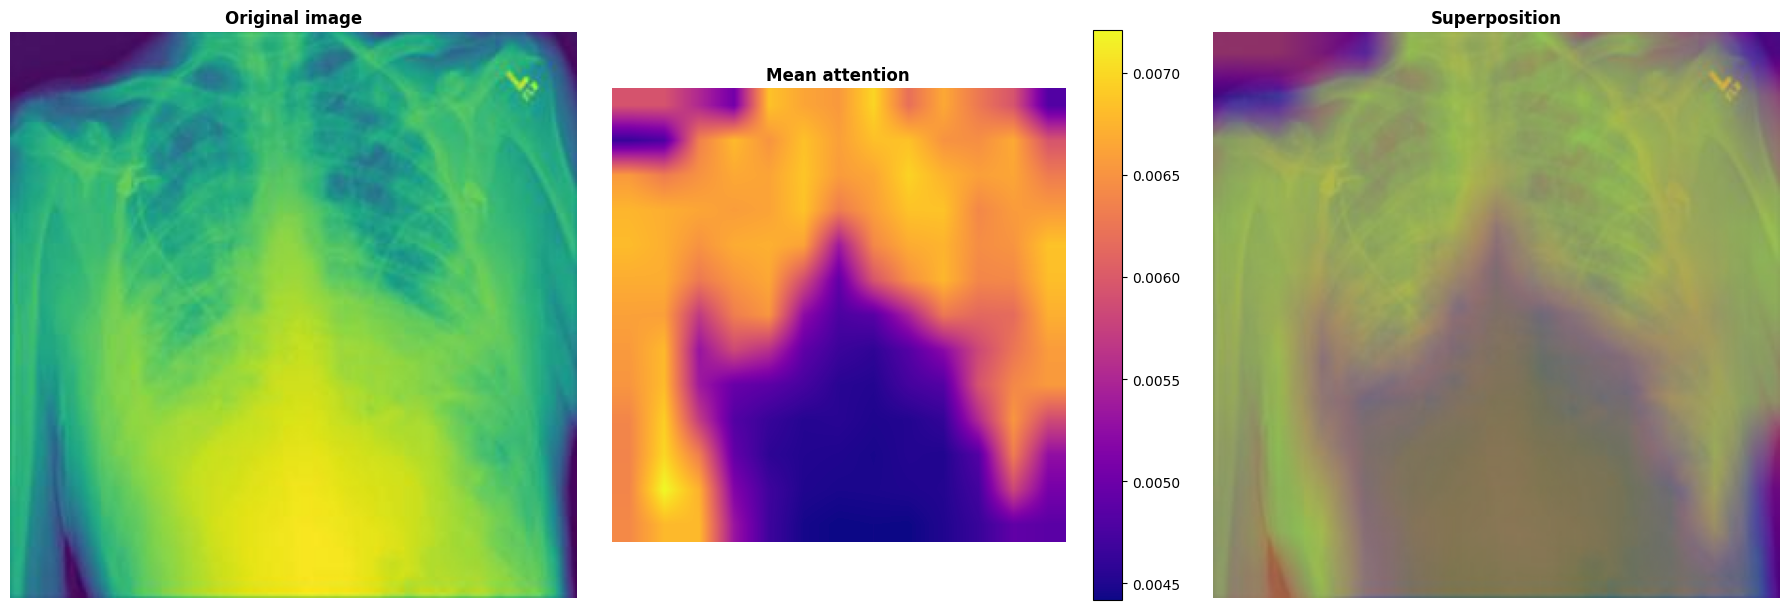

In [18]:
mean_attn = last_attn[:, 0, 1:].mean(dim=0).reshape(n_patches, n_patches).numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(first_image)
ax1.set_title(f'Original image', fontsize=12, fontweight='bold')
ax1.axis('off')

im2 = ax2.imshow(mean_attn, cmap='plasma', interpolation='bilinear')
ax2.set_title('Mean attention', fontsize=12, fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2)

ax3.imshow(first_image)
attn_resized = cv2.resize(mean_attn, (first_image.shape[1], first_image.shape[0]))
ax3.imshow(attn_resized, cmap='plasma', alpha=0.5, interpolation='bilinear')
ax3.set_title('Superposition', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()